# ToDo

## Path generation API
### Single Robot Path Generation
- Generate coverage path from given area map and list of relevant points (start, end, fuel).
- Generate fuel path from given fuel map and coverage path
- Generate combined path 

### Multiple Robot Path Generation
- Obtain area division map from DARP
- Pass area division map to all algos with relevant cell value to represent mapping area.
- Same interface as single robot path generation.

## Testing
### Functions to visualize


### Metrics
#### Percents
- **Coverage** - Percentage of non obstacle cells covered by the path.
- **Redundancy** - Percentage of cells from the path that have been revisited (backtracked).

#### Timings
- **Coverage Path computation time** - Time taken by the algorithm to compute the coverage path.
- **Fuel Path computation time** - Time taken to compute the refuel path.
- **Fuel dist map generation time** - Time required to generate the fuel distance map.

#### Numbers
- **Coverage cells** - Number of cells to be covered.
- **Non covered cells** - Cells that haven't been covered.
- **Backtrack** - Count of coverage path cells that have been revisited.
- **Coverage Path length** - Number of steps in the area coverage path.
- **Fuel Path length** - Number of steps in the refueling path.
- **Total Path length** - Sum of the above two points.
    
### Running Tests On
- Resolutions, Get obstacle maps of the following resolutions.
    - (32, 32)
    - (50, 50)
    - (144, 50)
    - (256, 144)
    - (256, 256)
- Obstacle types
    - None
    - Point obstacles (single cell obstacles generated randomly).
    - Region obstacles (region obstacles that have been painted).
        - Corners
        - Central
        - Caves
        - Pipes, Bottlenecks
    - Combination of both.

# Testing

In [15]:
# Global Import
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from copy import deepcopy
from tqdm.autonotebook import tqdm
from matplotlib.animation import FuncAnimation

# Local imports
from helpers import imshow, get_random_coords, is_valid, is_bounded

from cpp_algorithms.fuel_path.constants import OB, NO
from cpp_algorithms.fuel_path.fuel_path import splice_paths, get_fuel_paths
from cpp_algorithms.fuel_path.dist_matrix import dist_fill

In [2]:
# Constants
AMS_PATH = "./test_maps/" # Area Maps Paths
RES = [(32, 32),(50, 50),(50, 144),(144, 255),(256,256)]

## Helpers

In [3]:
def generate_no_obs_area_map(resolutions=RES):
    """
    resolutions : list of tuples [(rows, cols)]
    """
    area_maps = []
    for res in resolutions:
        area_maps.append(np.zeros(res))
    return area_maps

def get_area_map(path):
    """
    path : path to area map png, png should have only 
    0 255 as values.
    returns area_map with cell values
    obstacle : OBS
    non obstacle : NOB
    """
    am = np.array(Image.open(path))
    ma = np.array(am).mean(axis=2) == 255
    am = np.int8(np.zeros(ma.shape))
    am[ma] = NO
    am[~ma]  = OB
    return am

def get_area_map_list(folder_path=AMS_PATH):
    """
    folder_path : path to the folder contiaining the maps (.png)
    """
    ams = []
    for path in Path(folder_path).iterdir():
        try:
            ams.append(get_area_map(path))
        except:
            continue
            
    am_idx = np.array([am.size for am in ams]).argsort()
    return list(np.array(ams)[am_idx])

def generate_point_obstacles(area_map, p=0.5):
    area_map = area_map.copy()
    area_map[np.random.rand(*area_map.shape)<p] =  -1
    return area_map

## Testing Fuel Distance Map Generations

**Fuel Distance maps** generated from all the area maps
in the `test_maps` folder.  
Black points : Fuel

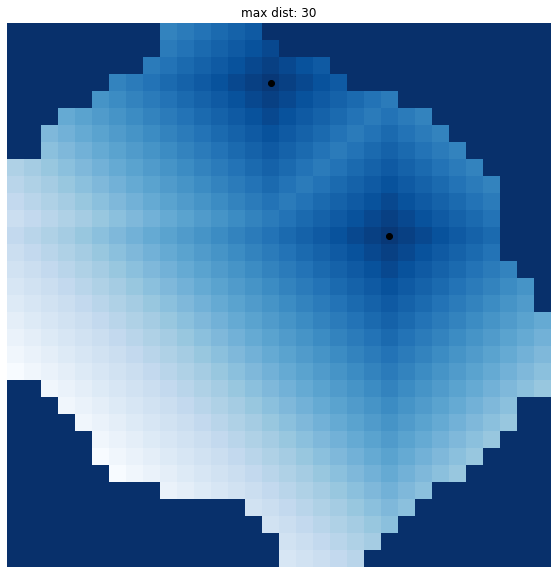

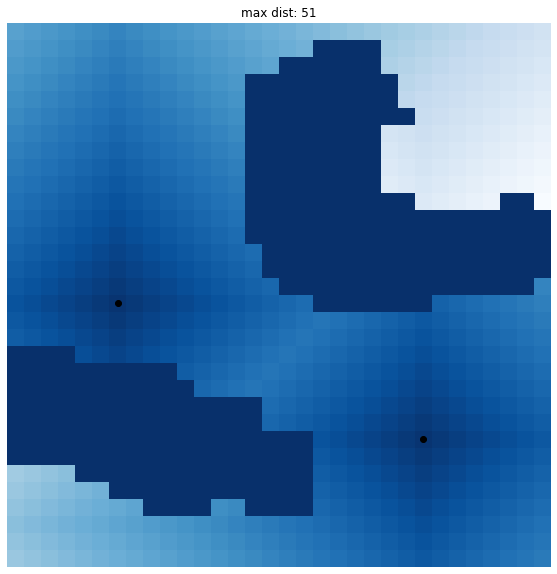

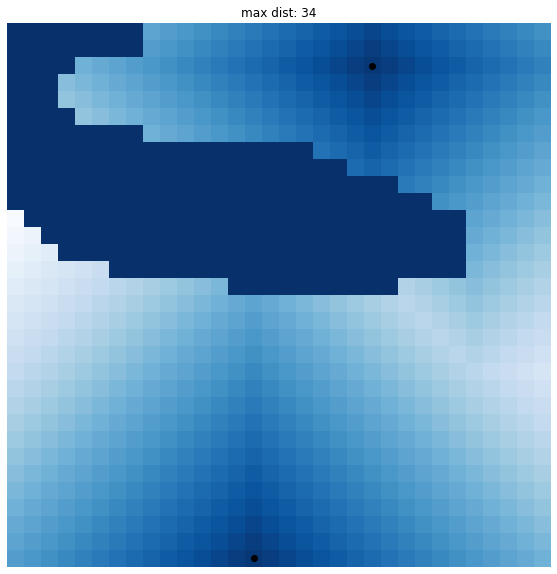

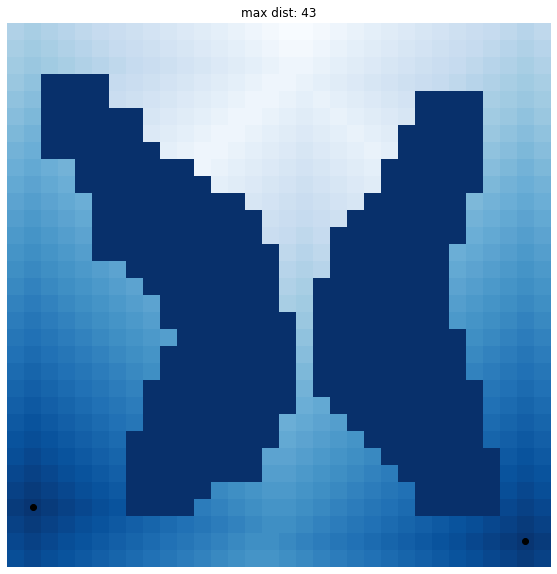

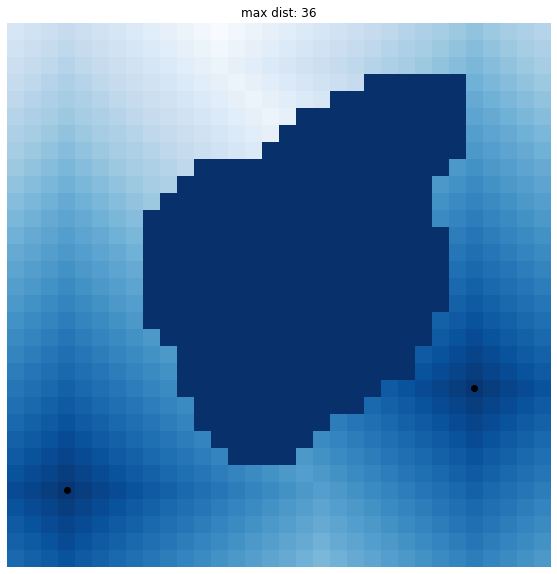

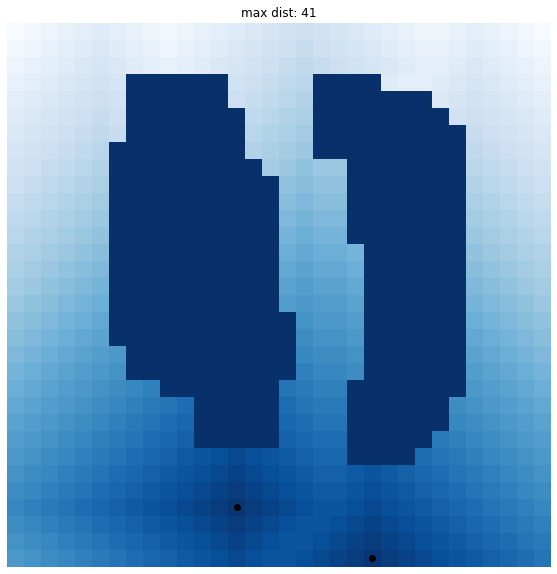

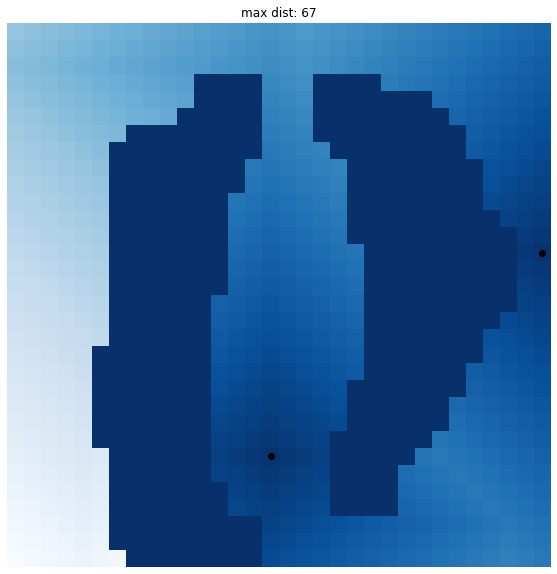

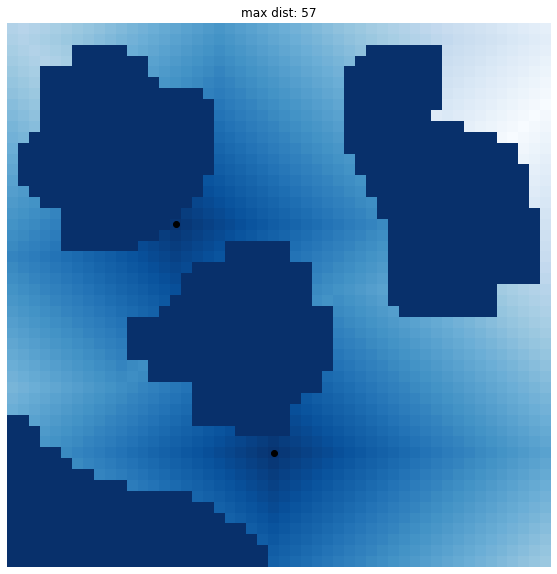

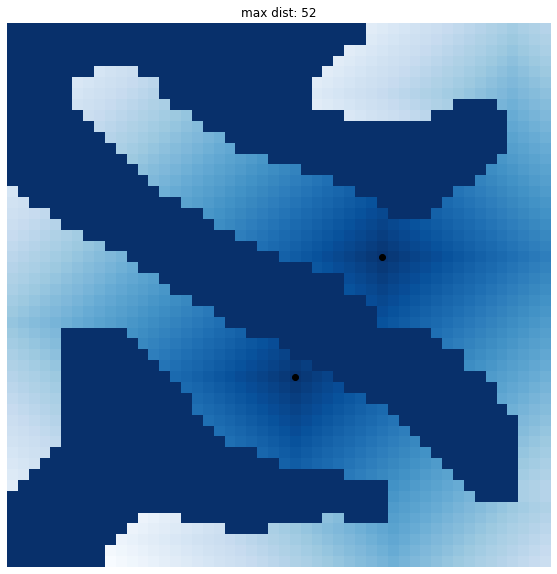

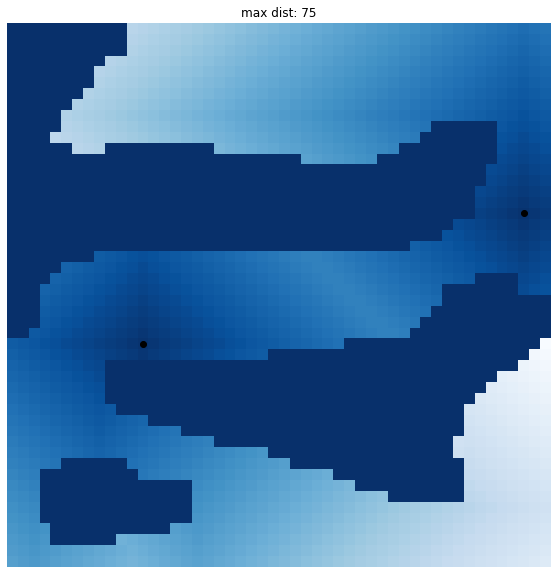

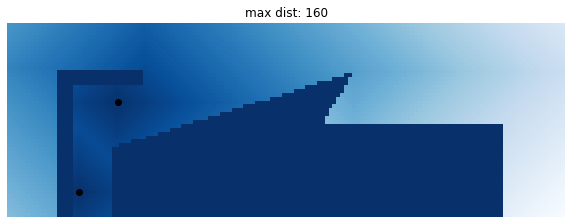

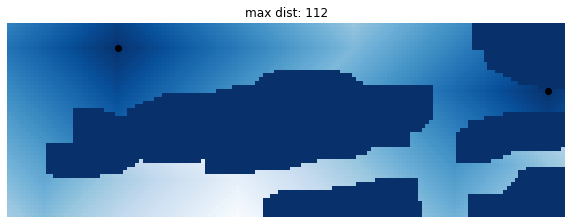

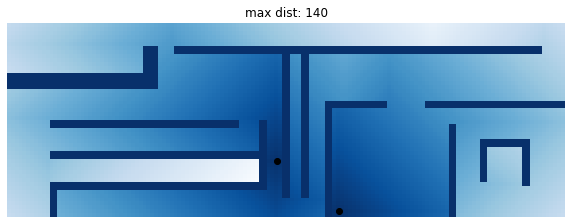

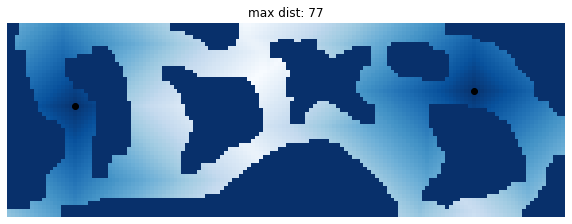

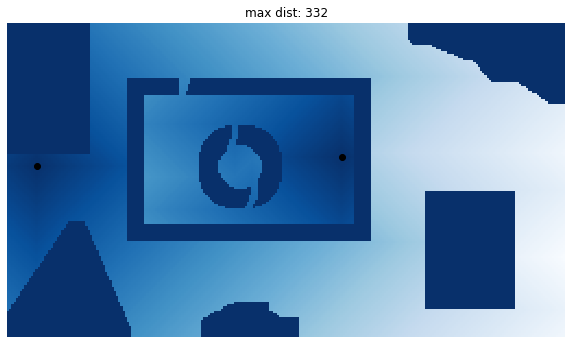

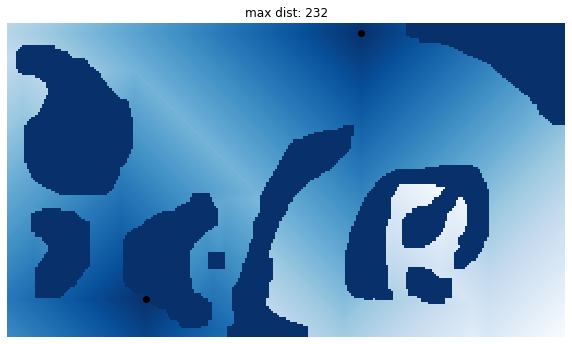

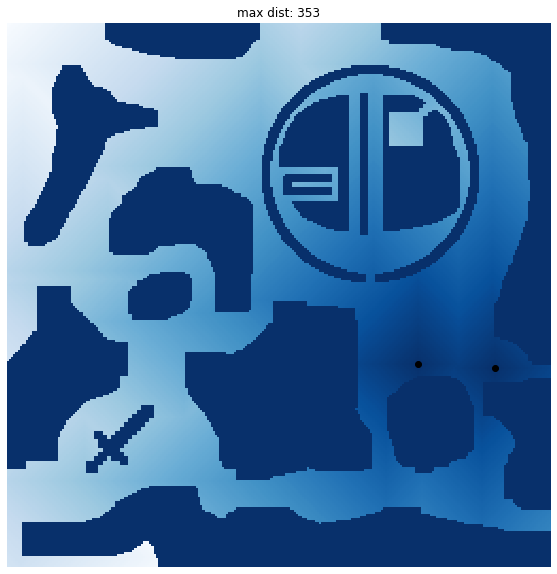

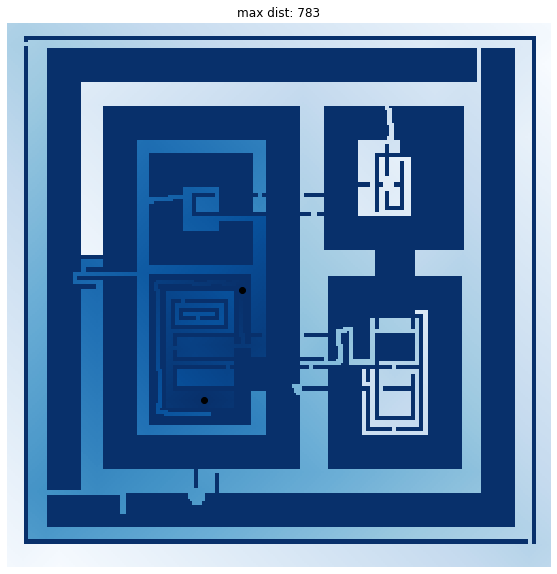

In [4]:
for am in get_area_map_list():
    fp = get_random_coords(am)
    dm  = dist_fill(am, fp,)
    imshow(dm,(10,10),cmap="Blues_r")
    x,y = np.array(fp).T
    plt.scatter(y,x, c="black")
    plt.title(f"max dist: {dm.max()}")

**Fuel Distance maps** generated from point obstacles added to no obstacle maps.  
Black points : Fuel

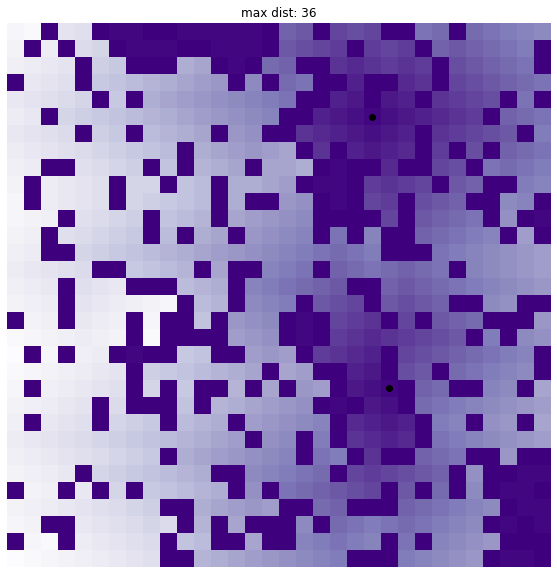

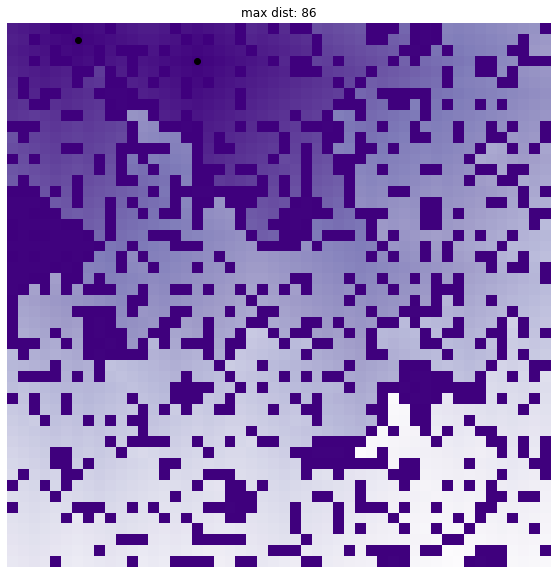

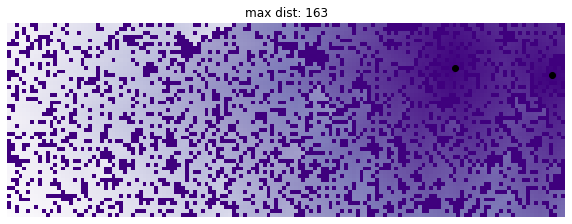

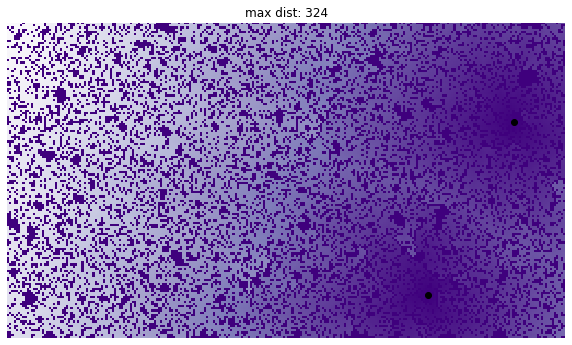

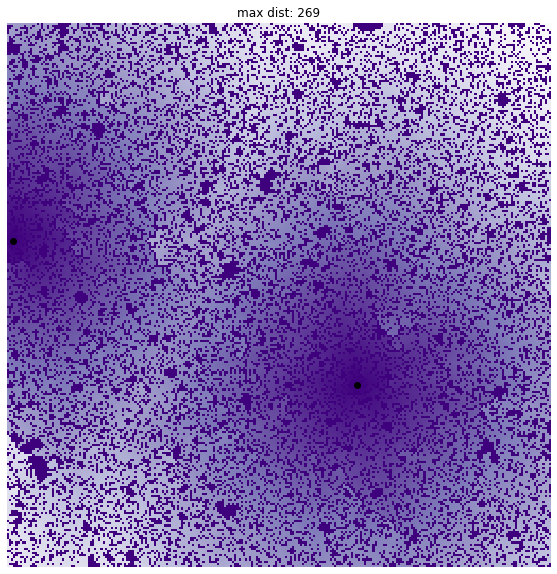

In [5]:
for am_ in generate_no_obs_area_map():
    am = generate_point_obstacles(am_, p=0.3)
    fp = get_random_coords(am)
    dm  = dist_fill(am, fp,)
    imshow(dm,(10,10),cmap="Purples_r")
    x,y = np.array(fp).T
    plt.scatter(y,x, c="black")
    plt.title(f"max dist: {dm.max()}")

## Dummy path generator

In [6]:
def get_next_point(dist_map, point, v_map):
    x,y = point
    points_ = [(x,y+1),(x,y-1),(x-1,y),(x+1,y)]
    sh = dist_map.shape
    
    max_ = -1
    d_vals = []
    v_vals = []
    
    points = []
    for p in points_:
        if is_bounded(p, sh) and dist_map[p] != OB:
            points.append(p)
            v_vals.append(v_map[p])
            d_vals.append(dist_map[p])
        
    d_vals = np.array(d_vals)
    v_vals = ~np.array(v_vals) # Not visited : True
    
    if v_vals.sum() == 0:
        return points[d_vals.argmin()]
    else:
        where = np.where(v_vals)[0]
        idx = where[d_vals[where].argmax()]
        return points[idx]

def traversal_path(dist_map, start):
    """
    dist_map : map of distances to the end
    start : (x,y) of the robot
    
    Assumption : end has value 0 and only
        a single end is present
    """
    shape = dist_map.shape
    v_map = (dist_map == OB).copy()
    end = tuple(np.array(np.where(dist_map==0)).flatten())
    
    point = start
    path = []
    try:
        while (~v_map).sum() > 0:
            path.append(point)
            v_map[point]  = True
            if point == end:
                break

            point = get_next_point(dist_map, point, v_map)
    except:
        return path
    return path

def dummy_coverage(area_map, start_point, end_point):
    """
    area_map : map pertaining to the area
    start_point : (x,y) where the drone starts cpp from
    end_point : (x,y) where the drone ends cpp at
    """
    assert is_valid(start_point, area_map), "invalid start"
    assert is_valid(end_point, area_map), "invalid end"
    
    dist_map = dist_fill(area_map, [end_point])
    return traversal_path(dist_map, start_point)

## Metrics

### Calculate the metrics

In [7]:
def printer(metrics):
    for m in metrics:
        print(f"{m.rjust(20)} : {metrics[m]}")
        
def coverage_metrics(area_map, path):
    """
    Returns a dict of metrics pertaining to area coverage.
    
    PARAMETERS
    ---
    area_map : -1 (obstacle), 0 valued 2 dim ndarray
    path : [(x1,y1),..., (xm,ym)]
    """
    path = np.array(path).T
    assert path.shape[0] == 2
    x,y = path
    
    p_len = path.shape[1]
    obs_map = area_map == -1
    obs_points = obs_map.sum()
    total_points_nobs = (~obs_map).sum()
    
    vis_map = obs_map.copy()
    vis_map[x,y] = True
    vis_points = vis_map.sum() - obs_points
    
    coverage = vis_points/total_points_nobs
    redundancy = 1-vis_points/p_len
    
    return {
        "points_to_visit":total_points_nobs,
        "obstacle_points":obs_points,
        "points_visited":vis_points,
        "coverage_path_len":p_len,
        "coverage":coverage,
        "redundancy":redundancy,
        "area_shape":area_map.shape
    }

def fuel_metrics(fuel_paths, fuel_capacity):
    """
    TODO : Need to complete this function, add more metrics.
    """
    fp_len = np.sum([len(fp) for fp in fuel_paths])*2
    return {
        "fuel_path_len": fp_len,
        "fuel_capacity": fuel_capacity
    }

### Display function

In [8]:
def path_show(area_map, coverage_path,fuel_paths=None, \
              dist_map=None, figsize=(7,7),s=7, alpha=0.5,
              cmap="Greys_r"):
    """
    Displays `area_map` with the path 
    taken by the drone overlaid ontop of 
    it.
    
    PARAMETERS
    ---
    area_map : -1 (obstacle), 0 valued 2-dim ndarray
    coverage_path : area coverage path [(x1,y1),..., (xm,ym)]
    fuel_paths : detour paths to refuel [[(x1,y1),..., (xn,yn)],...,[...]]
    dist_map : path showing dist gradients to the fuel points
    s : path marker size
    alpha : path marker alpha
    """
    x,y = np.array(coverage_path).T
    if dist_map is not None:
        imshow(dist_map,figsize,cmap=cmap)
    else:
        imshow(area_map,figsize,cmap=cmap)
    sd = 3 
    ad = 0.2
    plt.scatter(y,x,color="orange", s=s,alpha=alpha)
    plt.scatter(y[0],x[0],color="green", s=s+sd,alpha=alpha+ad)
    plt.scatter(y[-1],x[-1],color="red", s=s+sd,alpha=alpha+ad)

    if fuel_paths is not None:
        for fuel_path in fuel_paths:
            x,y = np.array(fuel_path).T
            plt.scatter(y,x,color="lightblue", s=s,alpha=alpha)
            plt.scatter(y[0],x[0],color="yellow", s=s+sd,alpha=alpha+ad)
            plt.scatter(y[-1],x[-1],color="cyan", s=s+sd,alpha=alpha+ad)

In [51]:
def path_animate(values, interval=10, repeat=False):
    disp_map = values["dist_map"]
    if disp_map is None:
        disp_map = values["area_map"]

    coverage_path = values['coverage_path']
    start_point = values["start_point"]
    end_point = values["end_point"]

    fuel_points = values["fuel_points"]
    if fuel_points is not None:
        fuel_paths = values["fuel_paths"]
        detour_idx = values["detour_idx"]
        full_path,detour_se_idx =  splice_paths(coverage_path, fuel_paths, detour_idx)
        det_se_flat = np.array(detour_se_idx).flatten()
    else:
        full_path = np.array(coverage_path)
        detour_se_idx = []
        det_se_flat = []

    frames = full_path.shape[0]

    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(disp_map, interpolation="none", cmap="cividis")
    ax.axis('off')

    x,y = np.array(full_path).T

    features = {
        "c_count":-1,
        "f_count":0,
        "f_num": -1,
        "fuelling": False,
        "text" : ax.text(0,-2," - "),
        "c_path" : ax.plot([],[], color="#FF69B4", alpha=0.8)[0],
        "f_path" : [ax.plot([],[], color="#BBDEFB", alpha=0.8)\
                    [0] for _ in range(len(detour_se_idx))]
    }

    if fuel_points is not None:
        f,g = np.array(fuel_points).T
        ax.scatter(g,f, s=10, color="#FFF")
    ax.scatter(start_point[1],start_point[0], s=12, color="#b2ebf2")
    ax.scatter(end_point[1],end_point[0], s=12, color="#FF3D00")

    def next_frame(i):
        is_fu = features["fuelling"]
        if not is_fu: 
            features["c_count"] = features["c_count"] + 1
        else:
            features["f_count"] = features["f_count"] + 1

        if i in det_se_flat:
            if not is_fu:
                ax.scatter(y[i],x[i], s=12, color="#ffca28")
                features["fuelling"] = True
                features["f_num"] += 1
            else:
                features["fuelling"] = False

        mode = "fuelling" if is_fu else "mapping"
        features["text"].set_text(f"{mode} :"+\
                f": total path left : {frames - i - 1} :"+\
                f": f_count :{features['f_count']} :"+\
                f": c_count :{features['c_count']} :"+\
                f": num_refuels:{features['f_num']+1}")

        if features["fuelling"]:
            f_num = features["f_num"]
            y_,x_ = features["f_path"][f_num].get_data()
            x_ = [*x_, x[i]]
            y_ = [*y_, y[i]]
            features["f_path"][f_num].set_data(y_,x_)
        else:
            y_,x_ = features["c_path"].get_data()
            x_ = [*x_, x[i]]
            y_ = [*y_, y[i]]
            features["c_path"].set_data(y_,x_)
    return FuncAnimation(fig, next_frame, frames=frames, interval=interval, repeat=repeat);

### Single Robot Test Function

In [61]:
"""
Test function to run tests on multiple image maps all at once.
"""
def cpp_tests_single_robot_multiple(cpp_algo, area_maps, no_end=False, fuel_paths=True):
    """
    Returns a DataFrame of test Results. 
    Tests are run with randomly generated points for start, end and fuel.
    
    PARAMETERS
    ---
    cpp_algo : the algorithm used to compute the path.
        function signature:
        no_end=True  : `cpp_algo(area_map, start_point)`
        no_end=False : `cpp_algo(area_map, start_point, end_point)`
    area_maps : list of area_map on which the path has to be calculated.
    no_end : if the `cpp_algo` requires an end point then should be true.
    fuel_paths : whether to calculate the fuel paths.
    """
    FC_MAX_DIST_MULTIPLIER = 5
    
    results = []
    for i,area_map in tqdm(enumerate(area_maps), total=len(area_maps)):
        t_metrics = {}
        f_metrics = {}
        start_point = get_random_coords(area_map,1)[0]
        end_point =   get_random_coords(area_map,1)[0]
        
        # Coverage Path calculation.
        t = time.time()
        if no_end:
            coverage_path = cpp_algo(area_map, start_point)
        else:
            coverage_path = cpp_algo(area_map, start_point, end_point)
        t_metrics["cp_compute_time"] = time.time() - t
        c_metrics = coverage_metrics(area_map, coverage_path)
        
        # Fuel Path calculation.
        if fuel_paths == True:
            n_fuel_stations = np.random.randint(1,5)
            fuel_points = get_random_coords(area_map, n_fuel_stations)
            dm = dist_fill(area_map, fuel_points)
            fuel_capacity = dm.max() * FC_MAX_DIST_MULTIPLIER
            
            t = time.time()
            dist_map, _, fuel_paths_, _ = get_fuel_paths(coverage_path, \
                                                             area_map, fuel_points, fuel_capacity)
            t_metrics["fp_compute_time"] = time.time() - t
            f_metrics = fuel_metrics(fuel_paths_, fuel_capacity)
            f_metrics["max_dist_fuel"] = dist_map.max()
        
        results.append({
            **t_metrics,
            **c_metrics,
            **f_metrics
        })
    return pd.DataFrame(results)

In [67]:
"""
Test Function to run tests on a single test map and show the results
"""
def cpp_tests_single_robot_single(cpp_algo, area_map, no_end=False, fuel_paths=True, \
                                  start_point=None, end_point=None, fuel_points=None,\
                                  fuel_capacity=None, fp_count=None, animate=False,\
                                  interval=10, repeat=False,printm=True, show_paths=True,\
                                  figsize=(7,7), cmap="Greys_r"):
    """
    Returns a DataFrame of test Results. 
    Tests are run with randomly generated points for start, end and fuel.
    
    PARAMETERS
    ---
    cpp_algo : the algorithm used to compute the path.
        function signature:
        no_end=True  : `cpp_algo(area_map, start_point)`
        no_end=False : `cpp_algo(area_map, start_point, end_point)`
    area_map : list of area_map on which the path has to be calculated.
    no_end : if the `cpp_algo` requires an end point then should be true.
    fuel_paths : whether to calculate the fuel paths.
    
    --
    If the following values are none random values are used:
        start_point : (x,y) starting point of the drone.
        end_point : (x,y) end point of the drone.
        fuel_points : [(x,y),...,(xn,yn)] fuel points.
        fuel_capacity : drone's fuel capacity.
        fp_count : If fuel_points is None, how many fuel points to generate.
    --
    
    animate : whether to animate the motion of the drone.
    interval : interval in ms between animation frames.
    repeat : whether to repeat the animation.
    printm : whether to print the drone metrics.
    show_paths : show the map.
    fig_size : size of the matplotlib figure to display the animation 
        or area map.
    cmap : Which matplotlib color map to use.
    """
    FC_MAX_DIST_MULTIPLIER = 5
    
    t_metrics = {}
    f_metrics = {}
    
    fuel_paths_ = None
    dist_map = None
    detour_idx = None
    fuel_capacity_list = None
    start_point = get_random_coords(area_map,1)[0] if start_point is None else start_point
    end_point =   get_random_coords(area_map,1)[0] if end_point is None else end_point
    
    # Coverage Path calculation.
    t = time.time()
    if no_end:
        coverage_path = cpp_algo(area_map, start_point)
    else:
        coverage_path = cpp_algo(area_map, start_point, end_point)
    t_metrics["cp_compute_time"] = time.time() - t
    c_metrics = coverage_metrics(area_map, coverage_path)
    
    if fuel_paths == True:
        if fuel_points is None:
            fp_count = np.random.randint(1,5) if fp_count is None else fp_count
            fuel_points = get_random_coords(area_map, fp_count)
            
        if fuel_capacity is None:
            dist_map = dist_fill(area_map, fuel_points)
            fuel_capacity = dist_map.max() * FC_MAX_DIST_MULTIPLIER

        t = time.time()
        dist_map, detour_idx, fuel_paths_, fuel_capacity_list = get_fuel_paths(coverage_path, \
                                                             area_map, fuel_points, fuel_capacity)
        
        t_metrics["fp_compute_time"] = time.time() - t
        f_metrics = fuel_metrics(fuel_paths_, fuel_capacity)
        f_metrics["max_dist_fuel"] = dist_map.max()
        
    metrics = {
        **t_metrics,
        **c_metrics,
        **f_metrics,
    }
    values = {
            "area_map":area_map,
            "coverage_path":coverage_path,
            "fuel_paths":fuel_paths_,
            "detour_idx":detour_idx,
            "dist_map":dist_map,
            "fuel_points":fuel_points,
            "fuel_capacity":fuel_capacity,
            "start_point": start_point,
            "end_point": end_point,
            "fuel_capacity_list": fuel_capacity_list
    }
        
    if not animate and show_paths:
        path_show(area_map, coverage_path, fuel_paths_, dist_map, figsize=figsize,cmap=cmap)
    
    if animate:
        values["__anim__"] = path_animate(values, interval, repeat)
        
    if printm:
        printer(metrics)
        
    return metrics, values

## Sandbox

In [12]:
%matplotlib notebook

In [54]:
# Area maps stored in the 'test_maps' folder
area_maps = get_area_map_list()
am = area_maps[:10]
cpp_tests_single_robot_multiple(dummy_coverage, am)

,cp_compute_time,fp_compute_time,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape,fuel_path_len,fuel_capacity,max_dist_fuel
0,0.041370,0.013059,716,308,708,722,0.988827,0.019391,"(32, 32)",300,88,22
1,0.027780,0.015481,725,299,667,707,0.920000,0.056577,"(32, 32)",188,96,24
2,0.025798,0.012071,794,230,783,804,0.986146,0.026119,"(32, 32)",152,164,41
3,0.014973,0.012727,654,370,594,640,0.908257,0.071875,"(32, 32)",236,164,41
4,0.011555,0.003983,723,301,349,420,0.482711,0.169048,"(32, 32)",126,200,50
5,0.022399,0.011004,689,335,689,722,1.000000,0.045706,"(32, 32)",104,164,41
6,0.007799,0.011090,639,385,248,267,0.388106,0.071161,"(32, 32)",34,124,31
7,0.038738,0.019396,1529,971,1458,1508,0.953564,0.033156,"(50, 50)",414,244,61
8,0.037141,0.006486,1318,1182,1232,1331,0.934750,0.074380,"(50, 50)",190,592,148
9,0.037424,0.020904,1472,1028,1450,1529,0.985054,0.051668,"(50, 50)",488,184,46


<IPython.core.display.Javascript object>


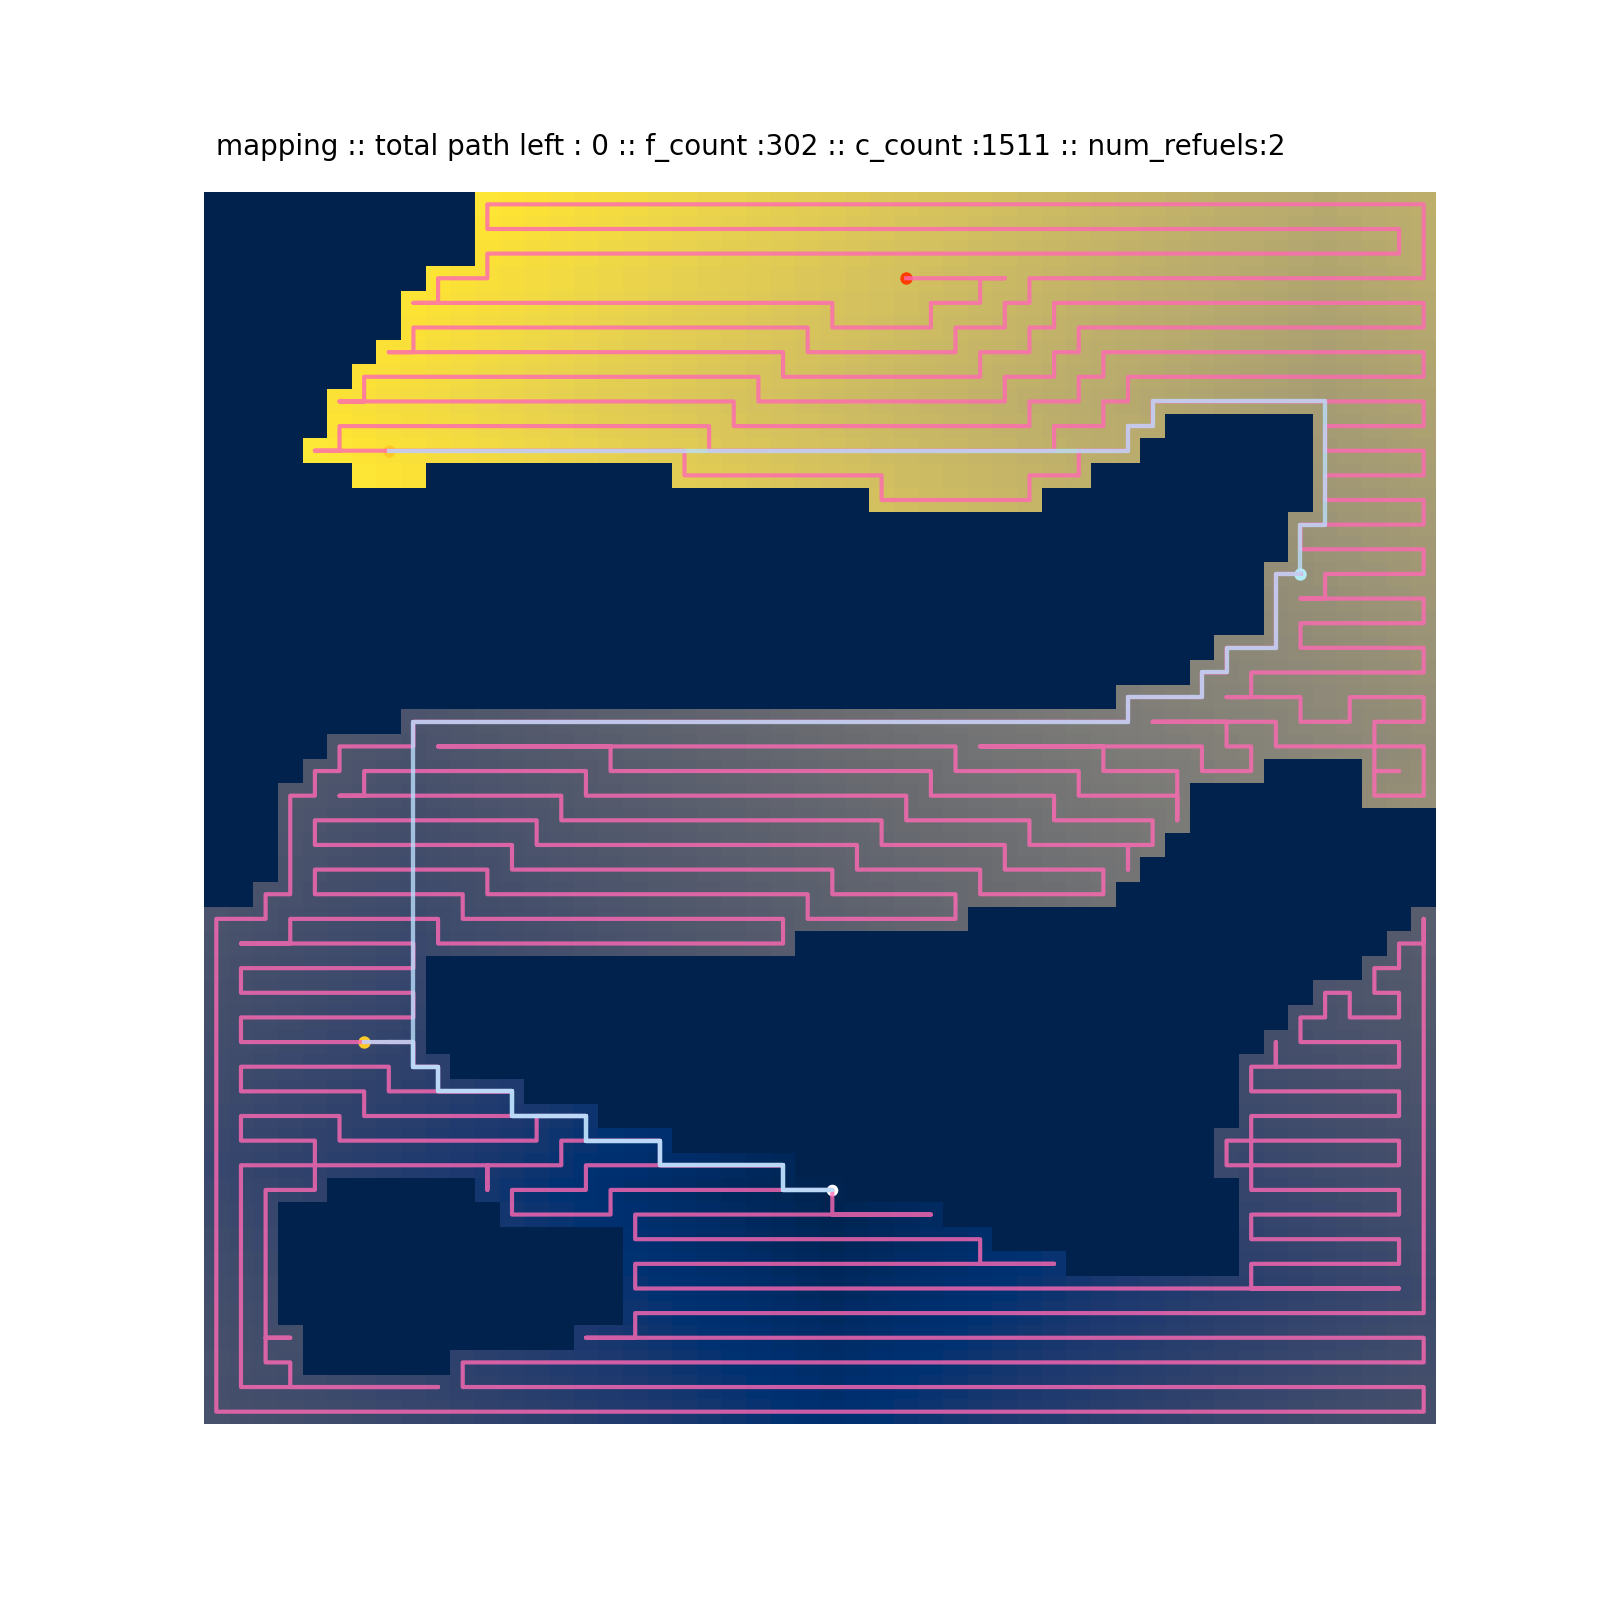

     cp_compute_time : 0.047170162200927734
     fp_compute_time : 0.009997129440307617
     points_to_visit : 1472
     obstacle_points : 1028
      points_visited : 1444
   coverage_path_len : 1511
            coverage : 0.9809782608695652
          redundancy : 0.04434149569821311
          area_shape : (50, 50)
       fuel_path_len : 306
       fuel_capacity : 645
       max_dist_fuel : 129


In [78]:
metrics, _ = cpp_tests_single_robot_single(dummy_coverage, area_maps[9], animate=True, interval=1)